Class Distribution:
Class 0: 1812 samples (90.60%)
Class 1: 171 samples (8.55%)
Class 2: 14 samples (0.70%)
Class 3: 3 samples (0.15%)

Full Results:
    lambda  lambda_klce  balanced_accuracy
0     0.00         -1.0           0.250000
1     0.00         -0.5           0.250000
2     0.00          0.0           0.250000
3     0.00          0.5           0.250000
4     0.00          1.0           0.250000
5     0.25         -1.0           0.250000
6     0.25         -0.5           0.250000
7     0.25          0.0           0.250000
8     0.25          0.5           0.250000
9     0.25          1.0           0.239641
10    0.50         -1.0           0.247928
11    0.50         -0.5           0.354972
12    0.50          0.0           0.250000
13    0.50          0.5           0.250000
14    0.50          1.0           0.250000
15    0.75         -1.0           0.250000
16    0.75         -0.5           0.250000
17    0.75          0.0           0.250000
18    0.75          0.5          

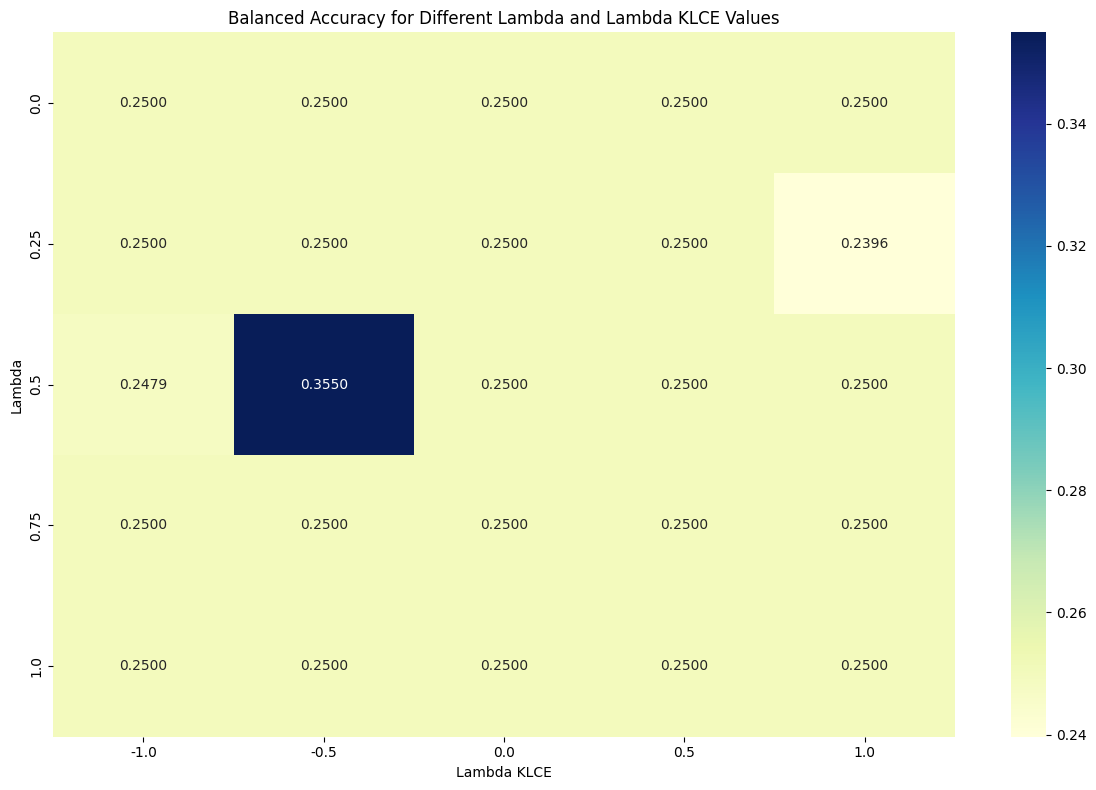

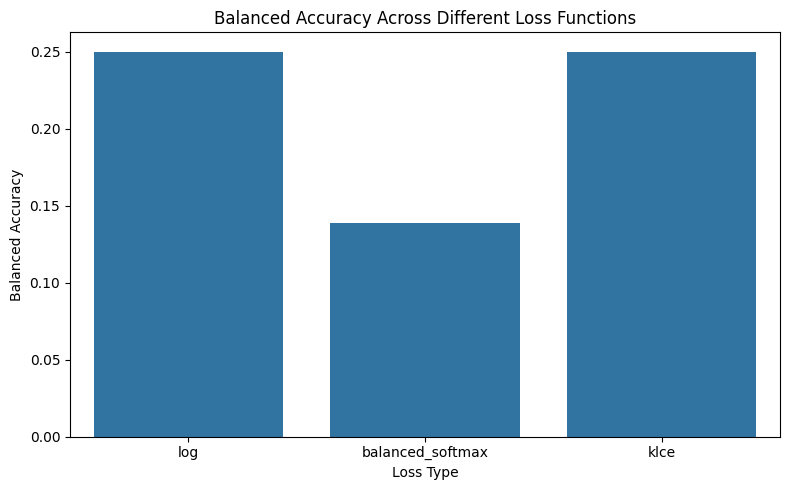

In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import optuna

class ImbalancedSyntheticDataset:
    def __init__(self, n_samples=1000, n_features=20, n_classes=4, imbalance_factor=0.1):
        """
        Generate a synthetic unbalanced dataset
        
        Args:
        - n_samples: Total number of samples
        - n_features: Number of features
        - n_classes: Number of classes
        - imbalance_factor: Controls the extreme imbalance in class distribution
        """
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Create extremely unbalanced class distribution
        class_dist = [imbalance_factor ** i for i in range(n_classes)]
        class_dist = np.array(class_dist) / np.sum(class_dist)
        
        # Generate samples
        self.X = np.random.randn(n_samples, n_features)
        self.y = np.random.choice(n_classes, size=n_samples, p=class_dist)
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=42
        )
        
        # Convert to torch tensors
        self.X_train = torch.FloatTensor(self.X_train)
        self.X_test = torch.FloatTensor(self.X_test)
        self.y_train = torch.LongTensor(self.y_train)
        self.y_test = torch.LongTensor(self.y_test)
        
        # Print class distribution
        unique, counts = np.unique(self.y, return_counts=True)
        print("Class Distribution:")
        for cls, count in zip(unique, counts):
            print(f"Class {cls}: {count} samples ({count/len(self.y)*100:.2f}%)")

class SimpleNet(torch.nn.Module):
    def __init__(self, n_features, n_classes, hidden_dim=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, n_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def balanced_softmax_loss(inputs, targets, class_weights):
    """
    Balanced Softmax Loss implementation
    """
    weights = class_weights[targets].float()
    loss = F.cross_entropy(inputs, targets, reduction='none')
    weighted_loss = (loss * weights).mean()
    return weighted_loss

def klce_loss(p_pred, p_target, baseline_loss, lambda_, lambda_klce):
    """
    KLCE Loss implementation
    """
    # Ensure `p_target` is a floating-point tensor
    p_target = p_target.float().unsqueeze(0).expand_as(p_pred)
    epsilon = 1e-8

    # Compute KL Divergence and Cross Entropy
    kl_divergence = torch.sum(p_pred * torch.log(p_pred / (p_target + epsilon)), dim=-1)
    cross_entropy = -torch.sum(p_target * torch.log(p_pred + epsilon), dim=-1)

    klce = (lambda_klce * cross_entropy) + kl_divergence

    return baseline_loss + (lambda_ * klce.mean())

def calculate_target_distribution(y, n_classes):
    """
    Calculate the target distribution for KLCE loss
    """
    # Initialize counts with dtype torch.long
    counts = torch.zeros(n_classes, dtype=torch.long)
    
    # Get unique class indices and their counts
    unique, unique_counts = torch.unique(y, return_counts=True)
    
    # Populate the counts tensor
    counts[unique] = unique_counts
    
    # Calculate class ratios
    class_ratios = counts / counts.sum()
    inverse_ratios = 1.0 / (class_ratios + 1e-8)
    
    # Target distribution
    target_distribution = inverse_ratios / inverse_ratios.sum()
    return target_distribution



In [17]:
dataset = ImbalancedSyntheticDataset(n_samples=2000, n_features=20, n_classes=4, imbalance_factor=0.5)

Class Distribution:
Class 0: 1022 samples (51.10%)
Class 1: 578 samples (28.90%)
Class 2: 275 samples (13.75%)
Class 3: 125 samples (6.25%)


# comparing f1_score

Class Distribution:
Class 0: 1022 samples (51.10%)
Class 1: 578 samples (28.90%)
Class 2: 275 samples (13.75%)
Class 3: 125 samples (6.25%)

Full Results:
    lambda  lambda_klce  f1_score
0     0.00         -1.0  0.175634
1     0.00         -0.5  0.172842
2     0.00          0.0  0.172842
3     0.00          0.5  0.175634
4     0.00          1.0  0.185439
5     0.25         -1.0  0.168874
6     0.25         -0.5  0.180355
7     0.25          0.0  0.190667
8     0.25          0.5  0.213923
9     0.25          1.0  0.212748
10    0.50         -1.0  0.168874
11    0.50         -0.5  0.168874
12    0.50          0.0  0.204435
13    0.50          0.5  0.240278
14    0.50          1.0  0.073869
15    0.75         -1.0  0.211981
16    0.75         -0.5  0.172500
17    0.75          0.0  0.211358
18    0.75          0.5  0.029412
19    0.75          1.0  0.029412
20    1.00         -1.0  0.182293
21    1.00         -0.5  0.221441
22    1.00          0.0  0.029412
23    1.00          0.5  0.02

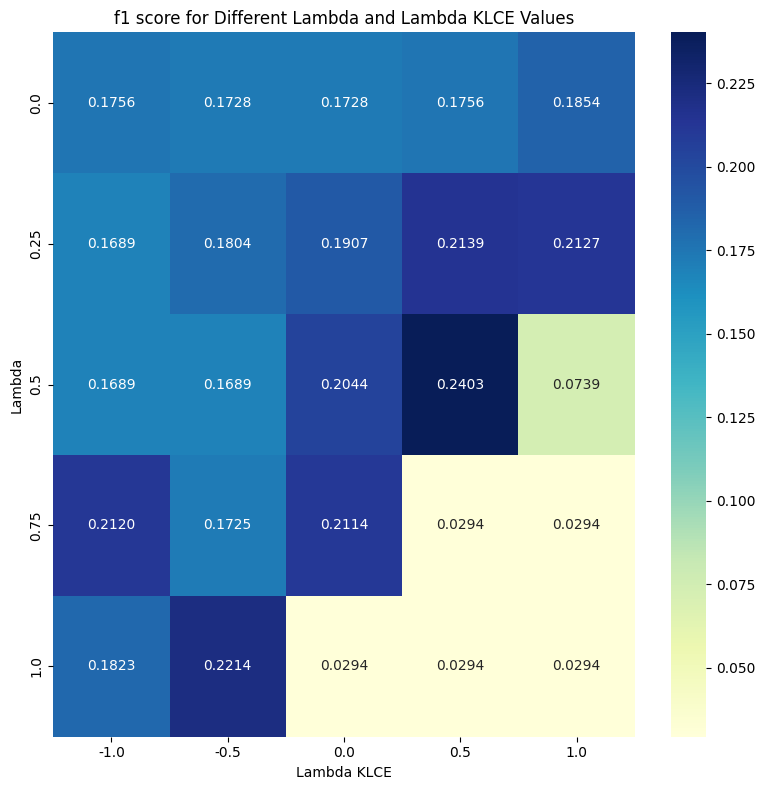

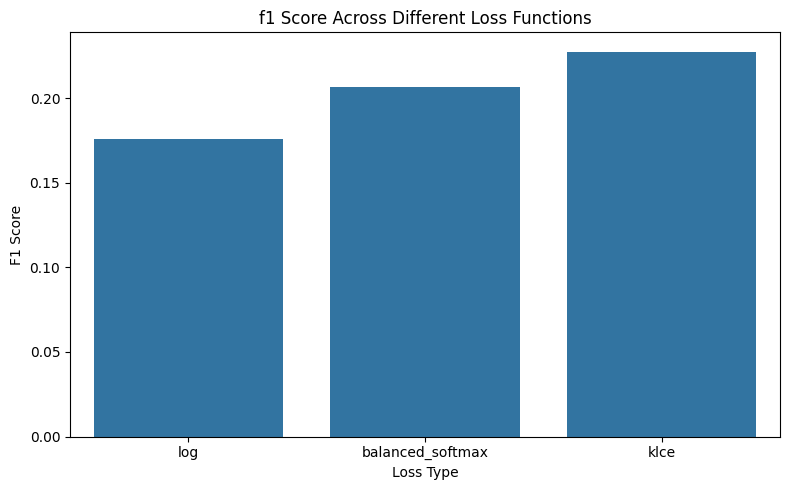

In [24]:



def train_and_evaluate(model, X_train, y_train, X_test, y_test, 
                       loss_type='log', lambda_=0.5, lambda_klce=0.5):
    """
    Train and evaluate the model with different loss functions
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Calculate class weights for balanced softmax
    unique, counts = torch.unique(y_train, return_counts=True)
    class_weights = 1.0 / (counts.float() + 1e-8)
    class_weights /= class_weights.sum()
    
    # Target distribution for KLCE
    target_distribution = calculate_target_distribution(y_train, len(unique))
    
    # Training
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        outputs = model(X_train)
        

        if loss_type == 'log':
            loss = F.nll_loss(outputs, y_train)
        elif loss_type == 'balanced_softmax':
            loss = balanced_softmax_loss(outputs, y_train, class_weights)
        elif loss_type == 'klce':
            baseline_loss = F.nll_loss(outputs, y_train)
            loss = klce_loss(
                torch.exp(outputs), 
                target_distribution.to(outputs.device), 
                baseline_loss, 
                lambda_, 
                lambda_klce
            )
        
        loss.backward()
        optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        preds = test_outputs.argmax(dim=1)
        
        f1 = f1_score(y_test.numpy(), preds.numpy(), average='macro')
        
    return f1

def hyperparameter_search():
    """
    Perform a grid search over lambda and lambda_klce for KLCE loss
    """
    # Create synthetic dataset
    dataset = ImbalancedSyntheticDataset(n_samples=2000, n_features=20, n_classes=4, imbalance_factor=0.5)
    
    # Prepare results storage
    results = []
    
    # Grid search parameters
    lambda_values = [0, 0.25, 0.5, 0.75, 1.0]
    lambda_klce_values = [-1.0, -0.5, 0, 0.5, 1.0]
    
    # Iterate through combinations
    for lambda_ in lambda_values:
        for lambda_klce in lambda_klce_values:
            # Reset model for each iteration
            model = SimpleNet(n_features=20, n_classes=4)
            
            # Train and evaluate
            f1 = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type='klce', 
                lambda_=lambda_, 
                lambda_klce=lambda_klce
            )
            
            # Store results
            results.append({
                'lambda': lambda_,
                'lambda_klce': lambda_klce,
                'f1_score': f1
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Pivot and plot heatmap
    pivot_df = results_df.pivot(index='lambda', columns='lambda_klce', values='f1_score')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.4f')
    plt.title('f1 score for Different Lambda and Lambda KLCE Values')
    plt.xlabel('Lambda KLCE')
    plt.ylabel('Lambda')
    plt.tight_layout()
    # plt.savefig('klce_hyperparameter_heatmap.png')
    
    # Save results
    # results_df.to_csv('klce_hyperparameter_results.csv', index=False)
    
    print("\nFull Results:")
    print(results_df)
    
    # Find best combination
    best_result = results_df.loc[results_df['f1_score'].idxmax()]
    print("\nBest Hyperparameters:")
    print(best_result)

def compare_loss_functions():
    """
    Compare different loss functions on the unbalanced dataset
    """
    # Create synthetic dataset
    dataset = ImbalancedSyntheticDataset(n_samples=2000, n_features=20, n_classes=4, imbalance_factor=0.5)
    
    # Loss types to compare
    loss_types = ['log', 'balanced_softmax', 'klce']
    
    # Results storage
    results = []
    
    for loss_type in loss_types:
        # Reset model
        model = SimpleNet(n_features=20, n_classes=4)
        
        # Train and evaluate with different loss types
        if loss_type == 'klce':
            # Use best lambda from previous search
            f1 = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type=loss_type, 
                lambda_=0.5, 
                lambda_klce=0.5
            )
        else:
            f1 = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type=loss_type
            )
        
        results.append({
            'Loss Type': loss_type,
            'F1 Score': f1
        })
    
    # Convert to DataFrame and display
    results_df = pd.DataFrame(results)
    print("\nLoss Function Comparison:")
    print(results_df)
    
    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Loss Type', y='F1 Score', data=results_df)
    plt.title('f1 Score Across Different Loss Functions')
    plt.tight_layout()
    # plt.savefig('loss_function_comparison.png')

def main():
    # Perform hyperparameter search for KLCE loss
    hyperparameter_search()
    
    # Compare different loss functions
    compare_loss_functions()

if __name__ == "__main__":
    main()

Class Distribution:
Class 0: 1022 samples (51.10%)
Class 1: 578 samples (28.90%)
Class 2: 275 samples (13.75%)
Class 3: 125 samples (6.25%)

Full Results:
    lambda  lambda_klce  balanced_accuracy
0     0.00         -1.0           0.249408
1     0.00         -0.5           0.250930
2     0.00          0.0           0.250930
3     0.00          0.5           0.249408
4     0.00          1.0           0.256170
5     0.25         -1.0           0.250000
6     0.25         -0.5           0.252789
7     0.25          0.0           0.255578
8     0.25          0.5           0.261494
9     0.25          1.0           0.261790
10    0.50         -1.0           0.250000
11    0.50         -0.5           0.250000
12    0.50          0.0           0.251056
13    0.50          0.5           0.293404
14    0.50          1.0           0.255735
15    0.75         -1.0           0.253254
16    0.75         -0.5           0.249704
17    0.75          0.0           0.230198
18    0.75          0.5     

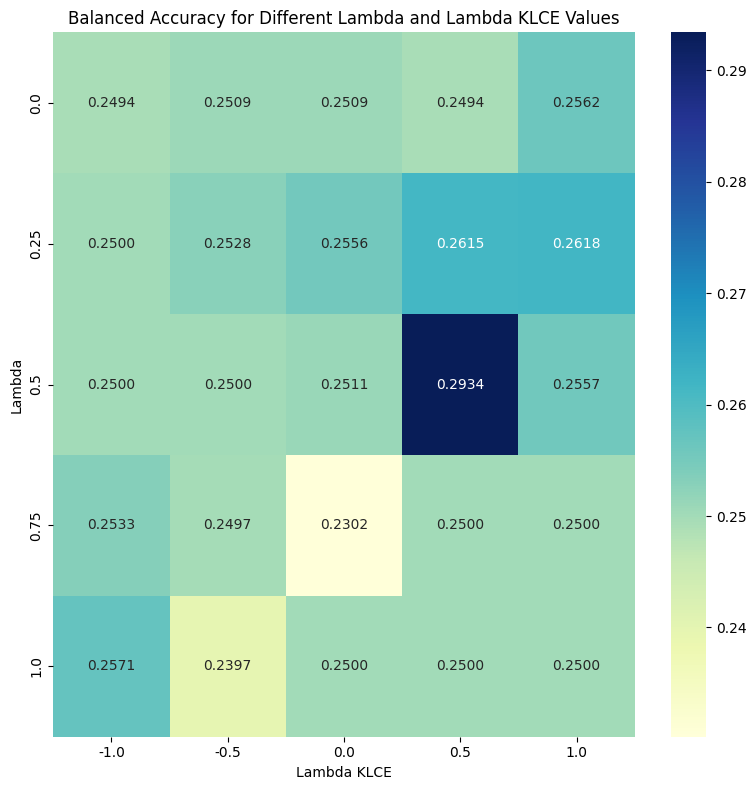

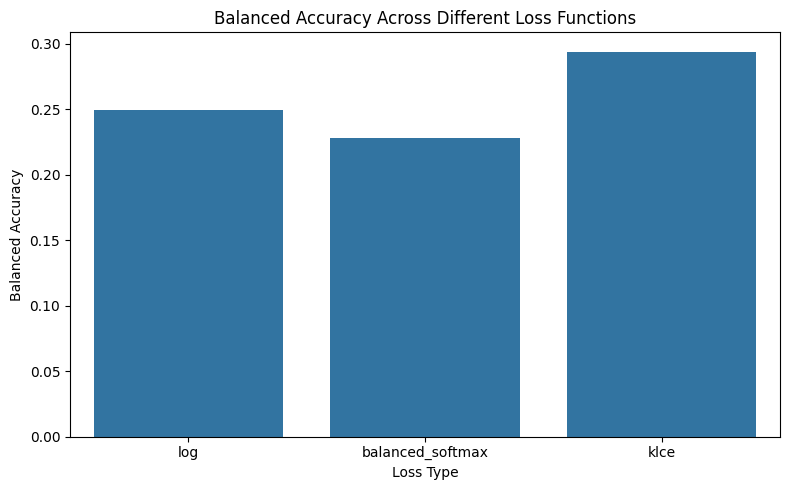

In [23]:



def train_and_evaluate(model, X_train, y_train, X_test, y_test, 
                       loss_type='log', lambda_=0.5, lambda_klce=0.5):
    """
    Train and evaluate the model with different loss functions
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Calculate class weights for balanced softmax
    unique, counts = torch.unique(y_train, return_counts=True)
    class_weights = 1.0 / (counts.float() + 1e-8)
    class_weights /= class_weights.sum()
    
    # Target distribution for KLCE
    target_distribution = calculate_target_distribution(y_train, len(unique))
    
    # Training
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        outputs = model(X_train)
        

        if loss_type == 'log':
            loss = F.nll_loss(outputs, y_train)
        elif loss_type == 'balanced_softmax':
            loss = balanced_softmax_loss(outputs, y_train, class_weights)
        elif loss_type == 'klce':
            baseline_loss = F.nll_loss(outputs, y_train)
            loss = klce_loss(
                torch.exp(outputs), 
                target_distribution.to(outputs.device), 
                baseline_loss, 
                lambda_, 
                lambda_klce
            )
        
        loss.backward()
        optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        preds = test_outputs.argmax(dim=1)
        
        balanced_acc = balanced_accuracy_score(y_test.numpy(), preds.numpy())
        
    return balanced_acc

def hyperparameter_search():
    """
    Perform a grid search over lambda and lambda_klce for KLCE loss
    """
    # Create synthetic dataset
    dataset = ImbalancedSyntheticDataset(n_samples=2000, n_features=20, n_classes=4, imbalance_factor=0.5)
    
    # Prepare results storage
    results = []
    
    # Grid search parameters
    lambda_values = [0, 0.25, 0.5, 0.75, 1.0]
    lambda_klce_values = [-1.0, -0.5, 0, 0.5, 1.0]
    
    # Iterate through combinations
    for lambda_ in lambda_values:
        for lambda_klce in lambda_klce_values:
            # Reset model for each iteration
            model = SimpleNet(n_features=20, n_classes=4)
            
            # Train and evaluate
            balanced_acc = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type='klce', 
                lambda_=lambda_, 
                lambda_klce=lambda_klce
            )
            
            # Store results
            results.append({
                'lambda': lambda_,
                'lambda_klce': lambda_klce,
                'balanced_accuracy': balanced_acc
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Pivot and plot heatmap
    pivot_df = results_df.pivot(index='lambda', columns='lambda_klce', values='balanced_accuracy')
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.4f')
    plt.title('Balanced Accuracy for Different Lambda and Lambda KLCE Values')
    plt.xlabel('Lambda KLCE')
    plt.ylabel('Lambda')
    plt.tight_layout()
    # plt.savefig('klce_hyperparameter_heatmap.png')
    
    # Save results
    # results_df.to_csv('klce_hyperparameter_results.csv', index=False)
    
    print("\nFull Results:")
    print(results_df)
    
    # Find best combination
    best_result = results_df.loc[results_df['balanced_accuracy'].idxmax()]
    print("\nBest Hyperparameters:")
    print(best_result)

def compare_loss_functions():
    """
    Compare different loss functions on the unbalanced dataset
    """
    # Create synthetic dataset
    dataset = ImbalancedSyntheticDataset(n_samples=2000, n_features=20, n_classes=4, imbalance_factor=0.5)
    
    # Loss types to compare
    loss_types = ['log', 'balanced_softmax', 'klce']
    
    # Results storage
    results = []
    
    for loss_type in loss_types:
        # Reset model
        model = SimpleNet(n_features=20, n_classes=4)
        
        # Train and evaluate with different loss types
        if loss_type == 'klce':
            # Use best lambda from previous search
            balanced_acc = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type=loss_type, 
                lambda_=0.5, 
                lambda_klce=0.5
            )
        else:
            balanced_acc = train_and_evaluate(
                model, 
                dataset.X_train, dataset.y_train, 
                dataset.X_test, dataset.y_test, 
                loss_type=loss_type
            )
        
        results.append({
            'Loss Type': loss_type,
            'Balanced Accuracy': balanced_acc
        })
    
    # Convert to DataFrame and display
    results_df = pd.DataFrame(results)
    print("\nLoss Function Comparison:")
    print(results_df)
    
    # Visualize
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Loss Type', y='Balanced Accuracy', data=results_df)
    plt.title('Balanced Accuracy Across Different Loss Functions')
    plt.tight_layout()
    # plt.savefig('loss_function_comparison.png')

def main():
    # Perform hyperparameter search for KLCE loss
    hyperparameter_search()
    
    # Compare different loss functions
    compare_loss_functions()

if __name__ == "__main__":
    main()